# 필수과제1
- 데이터셋을 드릴 예정 
- 이커머스 데이터를 통해 고객의 구매 패턴, 주기등을 파악을해서 기준을 정한다!
- 그 기준에 따라 RFM에 대한 측정 기준별 월별 지표가 만들어 질 것
- RFM 지표를 가지고 -> 세그먼트를 만들 수 있다. 
    - 방법론은 자유롭게 진행하시면 된다. 
    - kmeans 및 다른 기타 클러스터링을 진행하시면 되는데 ->내 데이터의 분포에 따른 적절한 클러스터링 작업을 해야 한다.
- 레이블이 만들어 지면
    - 레이블은 202201 ~ 202301 데이터라고 하면, 3개월 기준이라 가정하면 202204 데이터가 확보가 된다.
    - 202204 - (202201~202203의 주문데이터) 
    - 202205 - (202202~202204의 주문데이터) 
    - 202206 .. 월별 
- 월별의 레이블이 달라지게 만들어진다.
- 그 레이블의 기준으로 -> RFM 지표라 한다면 해당 지표가 어떤 식의 수렴하는 기준 값이 있는지 찾기
- 그 기준 값을 찾고 -> 해당기준 값으로 새로운 세그먼트를 만들어야 한다.
- 마지막 최종 비교는 
    - 기존 세그먼트 ( 레이블을 만든 세그먼트 )
    - 내가 인사이트를 찾아서 만든 세그먼트 
    - 둘 세그먼트의 차이를 비교분석 ( 기초통계, 카운팅 등 )
    
----
- 꼭 필요한 기준1
    - 월에 대한 데이터 기반 기준
    - 나만의 세그먼트의 RFM 지표 수렴하는 기준 
    - 세그먼트 2개의 값을 최종 비교
----
- 꼭 필요한 기준2
- 마지막 분석 코호트분석
    - 202204 기준으로 VIP라는 세그먼트의 고객들은 -> 어떤 식으로 세그먼트가 월별로 이동하는가?
    - 코호트가 어떤 식으로 세그먼트가 바뀌는지에 따른 시각화 자료

In [1]:
import pandas as pd
import os

os.chdir(r'..')

In [23]:
df = pd.read_excel('Online Retail.xlsx')

In [24]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [92]:
df['total_price']=df['Quantity']*df['UnitPrice']

### 시간별 추세 확인

In [70]:
df['year_month']=df['InvoiceDate'].dt.to_period('M')
df['year_week']=df['InvoiceDate'].dt.strftime('%Y-%U')
df['weekday']=df['InvoiceDate'].dt.dayofweek 
weekday_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

In [71]:
total_monthly=df.groupby('year_month').size().reset_index(name='total_orders')
total_weekly=df.groupby('year_week').size().reset_index(name='total_orders')
weekday_counts=df.groupby('weekday').size().reindex(range(7), fill_value = 0).reset_index(name='total_orders')
weekday_counts['weekday_label'] = weekday_labels

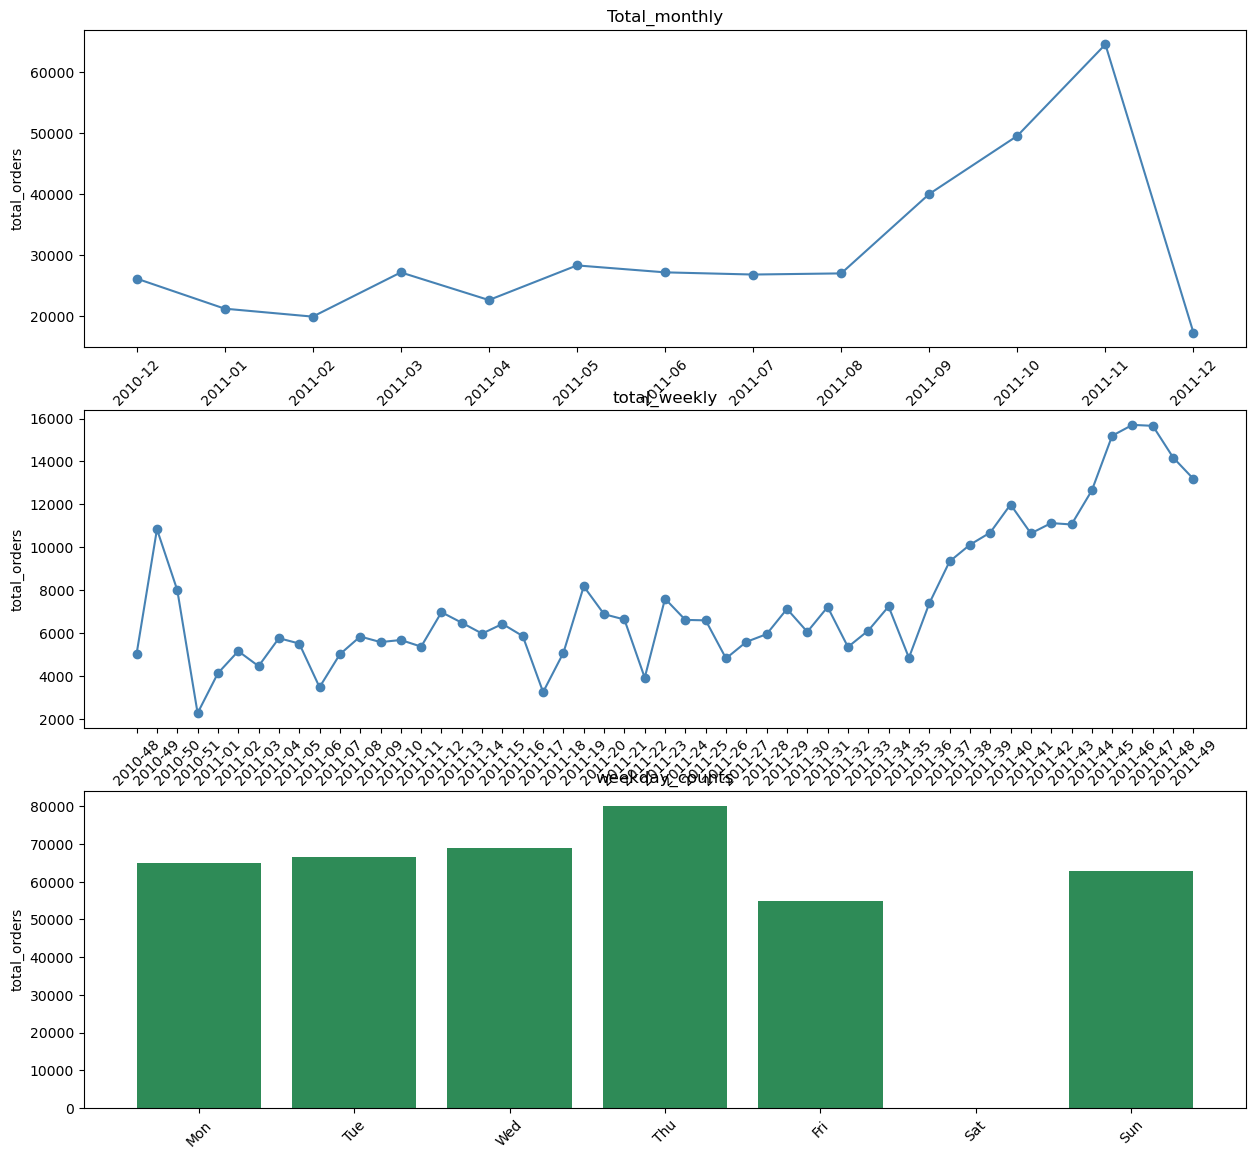

In [72]:
fig, axes = plt.subplots(3,1, figsize=(15,14))

##월별 트렌드
axes[0].plot(total_monthly['year_month'].astype(str), total_monthly['total_orders'], marker='o',color='steelblue')
axes[0].set_title('Total_monthly')
axes[0].set_ylabel('total_orders')
axes[0].tick_params(axis='x', rotation=45)

# 주별 트렌드
axes[1].plot(total_weekly['year_week'].astype(str), total_weekly['total_orders'], marker='o',color='steelblue')
axes[1].set_title('total_weekly')
axes[1].set_ylabel('total_orders')
axes[1].tick_params(axis='x', rotation=45)

# 요일별 트렌드
axes[2].bar(weekday_counts['weekday_label'].astype(str), weekday_counts['total_orders'],color='seagreen')
axes[2].set_title('weekday_counts')
axes[2].set_ylabel('total_orders')
axes[2].tick_params(axis='x', rotation=45)

### RFM 

In [138]:
month_start = df['InvoiceDate'].min()
month_end = df['InvoiceDate'].max()

month_range = pd.date_range(start=month_start, end=month_end, freq='MS')

In [139]:
rfm_list = []

for month_ref in month_range:
    month = month_ref + pd.DateOffset(months=1)

    mask = (df['InvoiceDate']>=month_ref)&(df['InvoiceDate']<month)
    temp = df.loc[mask].copy()

    if temp.empty:
        continue

    rfm = temp.groupby('CustomerID').agg({
        'InvoiceDate' : lambda x:(month-x.max()).days,
        'InvoiceNo' : 'nunique',
        'total_price' : 'sum'
    }).rename(columns = {
        'InvoiceDate':'Recency',
        'InvoiceNo':'Frequency',
        'total_price':'Monetary'
    }).reset_index()

    rfm['BaseMonth'] = month_ref.strftime('%Y-%m')
    rfm_list.append(rfm)

rfm_final = pd.concat(rfm_list, ignore_index=True)

In [140]:
rfm_final

,CustomerID,Recency,Frequency,Monetary,BaseMonth
0,12347.0,24,1,711.79,2010-12
1,12348.0,15,1,892.80,2010-12
2,12370.0,14,2,1868.02,2010-12
3,12377.0,11,1,1001.52,2010-12
4,12383.0,9,1,600.72,2010-12
...,...,...,...,...,...
13050,18245.0,29,1,894.25,2011-12
13051,18272.0,24,1,367.88,2011-12
13052,18273.0,24,1,51.00,2011-12
13053,18282.0,29,1,77.84,2011-12


### 세그먼트 기준 설정

In [141]:
rfm_final.describe()

,CustomerID,Recency,Frequency,Monetary
count,13055.000000,13055.000000,13055.000000,13055.000000
mean,15275.536729,14.254998,1.419839,682.604972
std,1726.224979,8.777234,1.272503,2455.121717
min,12346.000000,0.000000,1.000000,0.000000
25%,13798.000000,7.000000,1.000000,206.240000
50%,15235.000000,14.000000,1.000000,344.860000
75%,16774.000000,22.000000,1.000000,615.115000
max,18287.000000,30.000000,45.000000,168469.600000


In [143]:
rfm_final['Frequency'].value_counts()

Frequency
1     9963
2     2062
3      576
4      202
5       95
6       66
7       19
8       17
9       14
10       9
12       8
16       5
13       4
11       4
34       2
15       2
24       2
35       1
17       1
28       1
14       1
45       1
Name: count, dtype: int64

Text(0.5, 0, 'Purchase')

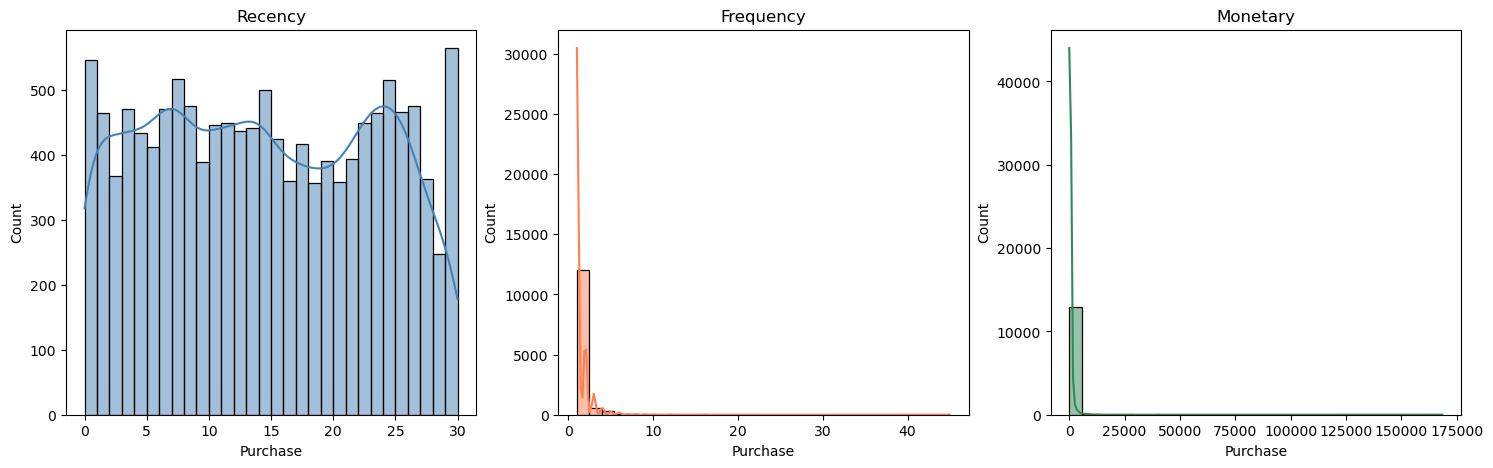

In [142]:
import seaborn as sns

plt.figure(figsize=(18,5))

##Recency
plt.subplot(1,3,1)
sns.histplot(rfm_final['Recency'], bins = 30, kde=True, color='steelblue')
plt.title('Recency')
plt.xlabel('Purchase')

##Recency
plt.subplot(1,3,2)
sns.histplot(rfm_final['Frequency'], bins = 30, kde=True, color='coral')
plt.title('Frequency')
plt.xlabel('Purchase')

##Recency
plt.subplot(1,3,3)
sns.histplot(rfm_final['Monetary'], bins = 30, kde=True, color='seagreen')
plt.title('Monetary')
plt.xlabel('Purchase')

In [148]:
def segment_by_quantile(series):
    return pd.qcut(series, q=3, labels=['Low', 'Mid', 'High'])

def segment_by_size(series):
    bins = [0, 15, 30, series.max()] 
    labels = ['Low', 'Mid', 'High']
    return pd.cut(series, bins=bins, labels=labels, right=True)

rfm_final['R_seg'] = segment_by_quantile(30-rfm_final['Recency'])
rfm_final['F_seg'] = segment_by_size(rfm_final['Frequency'])
rfm_final['M_seg'] = segment_by_quantile(rfm_final['Monetary'])
rfm_final['RFM_seg'] = (rfm_final['R_seg'].astype(str)+'-'
                        +rfm_final['F_seg'].astype(str)+'-'
                        +rfm_final['M_seg'].astype(str))

In [150]:
rfm_final.head()

,CustomerID,Recency,Frequency,Monetary,BaseMonth,R_seg,F_seg,M_seg,RFM_seg
0,12347.0,24,1,711.79,2010-12,Low,Low,High,Low-Low-High
1,12348.0,15,1,892.80,2010-12,Mid,Low,High,Mid-Low-High
2,12370.0,14,2,1868.02,2010-12,Mid,Low,High,Mid-Low-High
3,12377.0,11,1,1001.52,2010-12,Mid,Low,High,Mid-Low-High
4,12383.0,9,1,600.72,2010-12,Mid,Low,High,Mid-Low-High


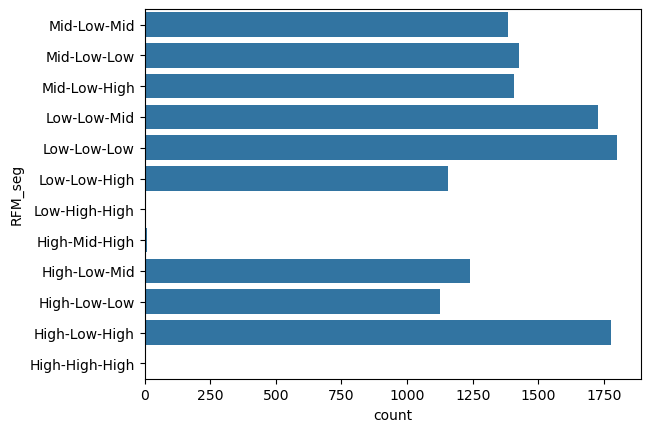

In [176]:
sns.countplot(rfm_final['RFM_seg'].sort_values(ascending=False))
plt.show()

### K-Means 기반 세그먼트 구분

In [153]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()

X = rfm_final[['Recency', 'Frequency', 'Monetary']]
X_scaled = scaler.fit_transform(X)

Text(0, 0.5, 'Inertia')

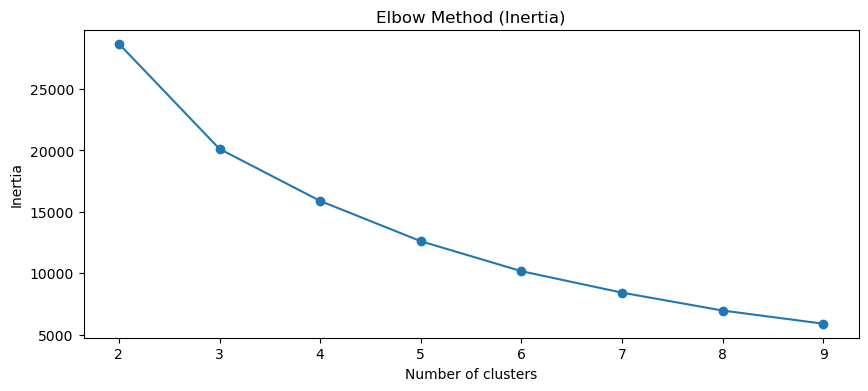

In [155]:
inertia = []

for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=1, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 4))
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [156]:
km_final = KMeans(n_clusters=3, random_state=1, n_init=10)
rfm_final['cluster'] = km_final.fit_predict(X_scaled)

cluster_summary = rfm_final.groupby('cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_summary)

           Recency  Frequency      Monetary
cluster                                    
0         7.148332   1.567682    657.531714
1        22.345059   1.135144    462.735925
2         5.837500  10.487500  19631.572250


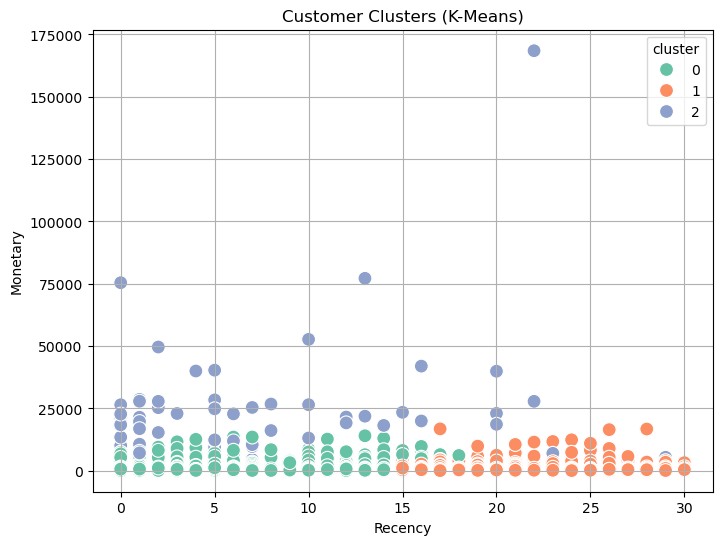

In [160]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_final, x='Recency', y='Monetary', hue='cluster', palette='Set2', s=100)
plt.title('Customer Clusters (K-Means)')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.grid(True)
plt.show()

### 세그먼트 비교

In [167]:
cross_tab = pd.crosstab(rfm_final['cluster'], rfm_final['RFM_seg'])
cross_tab

RFM_seg,High-High-High,High-Low-High,High-Low-Low,High-Low-Mid,High-Mid-High,Low-High-High,Low-Low-High,Low-Low-Low,Low-Low-Mid,Mid-Low-High,Mid-Low-Low,Mid-Low-Mid
cluster,,,,,,,,,,,,
0,0,1728,1127,1238,0,0,2,0,0,995,894,879
1,0,0,0,0,0,0,1146,1800,1727,401,531,507
2,3,50,0,0,9,1,6,0,0,11,0,0


In [169]:
cross_tab_rate = pd.crosstab(rfm_final['cluster'], rfm_final['RFM_seg'], normalize='index') * 100
cross_tab_rate.round(2)

RFM_seg,High-High-High,High-Low-High,High-Low-Low,High-Low-Mid,High-Mid-High,Low-High-High,Low-Low-High,Low-Low-Low,Low-Low-Mid,Mid-Low-High,Mid-Low-Low,Mid-Low-Mid
cluster,,,,,,,,,,,,
0,0.00,25.18,16.42,18.04,0.00,0.00,0.03,0.00,0.00,14.50,13.03,12.81
1,0.00,0.00,0.00,0.00,0.00,0.00,18.75,29.45,28.26,6.56,8.69,8.30
2,3.75,62.50,0.00,0.00,11.25,1.25,7.50,0.00,0.00,13.75,0.00,0.00


### 코호트 분석

In [219]:
rfm_cohort = rfm_final[['CustomerID','BaseMonth','R_seg']].copy()

In [220]:
rfm_cohort['BaseMonth'] = pd.to_datetime(rfm_cohort['BaseMonth'])
rfm_cohort['CohortMonth'] = rfm_cohort.groupby('CustomerID')['BaseMonth'].transform('min')

In [221]:
def get_month_difference(df, col1, col2):
    year_diff = df[col1].dt.year - df[col2].dt.year
    month_diff = df[col1].dt.month - df[col2].dt.month
    return year_diff * 12 + month_diff

rfm_cohort['CohortIndex'] = get_month_difference(rfm_cohort, 'BaseMonth', 'CohortMonth')
cohort_counts = rfm_cohort.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

cohort_pivot = cohort_counts.pivot_table(index='CohortMonth',
                                         columns='CohortIndex',
                                         values='CustomerID')

cohort_sizes = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0) * 100

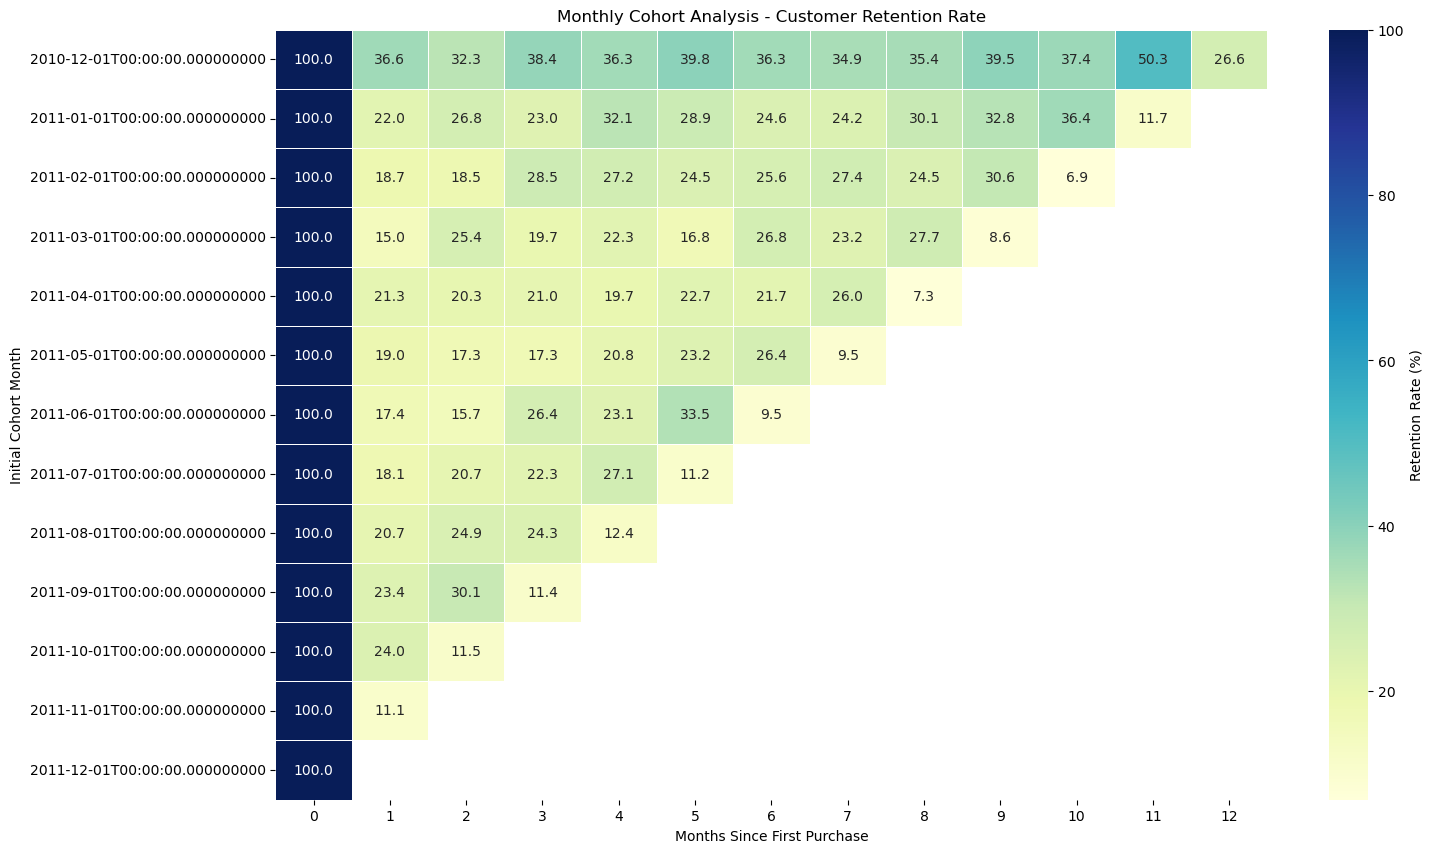

In [222]:
plt.figure(figsize=(16, 10))
sns.heatmap(retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            fmt='.1f',
            cmap='YlGnBu',
            linewidths=.5,
            cbar_kws={'label': 'Retention Rate (%)'})

plt.title('Monthly Cohort Analysis - Customer Retention Rate')
plt.ylabel('Initial Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.yticks(rotation=0)
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_47676\494178404.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Figure size 1600x1000 with 0 Axes>

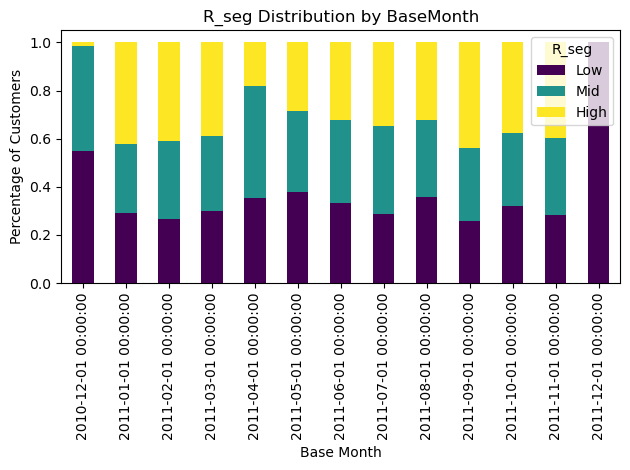

In [223]:
rfm_final_rseg_counts = rfm_final.groupby(['BaseMonth', 'R_seg'])['CustomerID'].nunique().unstack(fill_value=0)
rfm_final_rseg_percentages = rfm_final_rseg_counts.apply(lambda x: x / x.sum(), axis=1)

plt.figure(figsize=(16, 10))
rfm_final_rseg_percentages.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('R_seg Distribution by BaseMonth')
plt.ylabel('Percentage of Customers')
plt.xlabel('Base Month')
plt.legend(title='R_seg')
plt.tight_layout()
plt.show()